In [1]:
from utils.load_results import *
from utils.plot_helpers import *

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import torch
from utils.analysis_from_interaction import *
from language_analysis_local import TopographicSimilarityConceptLevel, encode_target_concepts_for_topsim
import os
if not os.path.exists('analysis'):
    os.makedirs('analysis')

In [2]:
datasets = ['(3,4)', '(3,8)', '(3,16)', '(4,4)', '(4,8)', '(5,4)']
n_values = [4, 8, 16, 4, 8, 4]
n_attributes = [3, 3, 3, 4, 4, 5]
n_epochs = 300
n_datasets = len(datasets)
paths = ['results/' + d + '_game_size_10_vsf_3' for d in datasets]

In [3]:
datasets = ['(3,4)',]
n_values = [4,]
n_attributes = [3,]
paths = ['results/' + d + '_game_size_10_vsf_3' for d in datasets]

In [74]:
context_unaware = False # whether original or context_unaware simulations are evaluated
if context_unaware:
    setting = 'context_unaware'
else:
    setting = 'standard'

### See which messages are produced for which concepts

In [75]:
# go through all datasets
for i, d in enumerate(datasets):
    # select first run
    path_to_run = paths[i] + '/' + str(setting) +'/' + str(0) + '/'
    path_to_interaction_train = (path_to_run + 'interactions/train/epoch_' + str(n_epochs) + '/interaction_gpu0')
    path_to_interaction_val = (path_to_run + 'interactions/validation/epoch_' + str(n_epochs) + '/interaction_gpu0')
    interaction = torch.load(path_to_interaction_train)
    print(path_to_interaction_train)

    messages = interaction.message.argmax(dim=-1)
    messages = [msg.tolist() for msg in messages]
    sender_input = interaction.sender_input
    print(sender_input.shape)
    n_targets = int(sender_input.shape[1]/2)
    # get target objects and fixed vectors to re-construct concepts
    target_objects = sender_input[:, :n_targets]
    target_objects = k_hot_to_attributes(target_objects, n_values[i])
    # concepts are defined by a list of target objects (here one sampled target object) and a fixed vector
    (objects, fixed) = retrieve_concepts_sampling(target_objects, all_targets=True)
    concepts = list(zip(objects, fixed))

    # get distractor objects to re-construct context conditions
    distractor_objects = sender_input[:, n_targets:]
    distractor_objects = k_hot_to_attributes(distractor_objects, n_values[i])
    context_conds = retrieve_context_condition(objects, fixed, distractor_objects)

    # get random qualitative samples
    #fixed_index = random.randint(0, n_attributes[i]-1) # define a fixed index for the concept
    n_fixed = random.randint(1, n_attributes[i]) # how many fixed attributes?
    n_fixed = 3
    fixed_indices = random.sample(range(0, n_attributes[i]), k=n_fixed) # select which attributes are fixed
    #fixed_value = random.randint(0, n_values[i]-1) # define a fixed value for this index
    fixed_values = random.sample(range(0, n_values[i]), k=n_fixed)
    print(n_fixed, fixed_indices, fixed_values)
    #index_threshold = 20000 # optional: define some index threshold to make sure that examples are not taken from the beginning of training
    # TODO: adapt this loop such that multiple indices can be fixed
    all_for_this_concept = []
    for idx, (t_objects, t_fixed) in enumerate(concepts):
        #if sum(t_fixed) == 1 and t_fixed[fixed_index] == 1:# and idx > index_threshold:
        if sum(t_fixed) == n_fixed and all(t_fixed[fixed_index] == 1 for fixed_index in fixed_indices):
            for t_object in t_objects:
                if all(t_object[fixed_index] == fixed_values[j] for j, fixed_index in enumerate(fixed_indices)):
                    all_for_this_concept.append((idx, t_object, t_fixed, context_conds[idx], messages[idx]))
    if len(all_for_this_concept) > 0:
        sample = random.sample(all_for_this_concept, 20)
        column_names = ['game_nr', 'object', 'fixed indices', 'context condition', 'message']
        df = pd.DataFrame(sample, columns=column_names)
        df.to_csv('analysis/quali_' + str(d) + '_' + str(setting) + '_' + str(sample[0][1]) + ',' + str(t_fixed) + '.csv', index=False)
        print('saved ' + 'analysis/quali_' + str(d) + '_' + str(setting) + '_' + str(sample[0][1]) + ',' + str(t_fixed) + '.csv')
    else:
        raise ValueError("sample for dataset " + str(d) + " could not be generated")

results/(3,4)_game_size_10_vsf_3/standard/0/interactions/train/epoch_300/interaction_gpu0
torch.Size([1807, 20, 12])
3 [1, 0, 2] [3, 0, 2]
saved analysis/quali_(3,4)_standard_[0. 3. 2.],[1. 1. 1.].csv


In [73]:
df = pd.read_csv('analysis/quali_(3,4)_context_unaware_[0. 2. 1.],[1. 1. 1.].csv')
df

,game_nr,object,fixed indices,context condition,message
0,766,[0. 2. 1.],[1. 1. 1.],0,"[2, 2, 2, 0]"
1,551,[0. 2. 1.],[1. 1. 1.],2,"[2, 2, 2, 0]"
2,1096,[0. 2. 1.],[1. 1. 1.],1,"[2, 2, 2, 0]"
3,1096,[0. 2. 1.],[1. 1. 1.],1,"[2, 2, 2, 0]"
4,827,[0. 2. 1.],[1. 1. 1.],2,"[2, 2, 2, 0]"
5,1171,[0. 2. 1.],[1. 1. 1.],0,"[2, 2, 2, 0]"
6,1171,[0. 2. 1.],[1. 1. 1.],0,"[2, 2, 2, 0]"
7,1348,[0. 2. 1.],[1. 1. 1.],2,"[2, 2, 2, 0]"
8,908,[0. 2. 1.],[1. 1. 1.],0,"[2, 2, 2, 0]"
9,1096,[0. 2. 1.],[1. 1. 1.],1,"[2, 2, 2, 0]"


In [71]:
df = pd.read_csv('analysis/quali_(3,4)_context_unaware_[3. 1. 2.],[1. 1. 1.].csv')
df

,game_nr,object,fixed indices,context condition,message
0,1258,[3. 1. 2.],[1. 1. 1.],0,"[13, 13, 13, 0]"
1,218,[3. 1. 2.],[1. 1. 1.],0,"[13, 13, 13, 0]"
2,1479,[3. 1. 2.],[1. 1. 1.],1,"[13, 13, 13, 0]"
3,1679,[3. 1. 2.],[1. 1. 1.],0,"[13, 13, 13, 0]"
4,1547,[3. 1. 2.],[1. 1. 1.],2,"[13, 13, 13, 0]"
5,1258,[3. 1. 2.],[1. 1. 1.],0,"[13, 13, 13, 0]"
6,863,[3. 1. 2.],[1. 1. 1.],1,"[13, 13, 13, 0]"
7,650,[3. 1. 2.],[1. 1. 1.],2,"[13, 13, 13, 0]"
8,605,[3. 1. 2.],[1. 1. 1.],1,"[13, 13, 13, 0]"
9,362,[3. 1. 2.],[1. 1. 1.],2,"[13, 13, 13, 0]"


In [76]:
df = pd.read_csv('analysis/quali_(3,4)_standard_[0. 3. 2.],[1. 1. 1.].csv')
df

,game_nr,object,fixed indices,context condition,message
0,1384,[0. 3. 2.],[1. 1. 1.],2,"[1, 1, 1, 0]"
1,90,[0. 3. 2.],[1. 1. 1.],1,"[1, 1, 1, 0]"
2,1384,[0. 3. 2.],[1. 1. 1.],2,"[1, 1, 1, 0]"
3,1183,[0. 3. 2.],[1. 1. 1.],1,"[11, 1, 1, 0]"
4,1798,[0. 3. 2.],[1. 1. 1.],0,"[11, 1, 9, 0]"
5,1483,[0. 3. 2.],[1. 1. 1.],2,"[1, 1, 14, 0]"
6,389,[0. 3. 2.],[1. 1. 1.],0,"[1, 1, 14, 0]"
7,1535,[0. 3. 2.],[1. 1. 1.],0,"[11, 1, 1, 0]"
8,1535,[0. 3. 2.],[1. 1. 1.],0,"[11, 1, 1, 0]"
9,1699,[0. 3. 2.],[1. 1. 1.],1,"[1, 1, 9, 0]"


In [65]:
df = pd.read_csv('analysis/quali_(3,4)_standard_[2. 3. 1.],[1. 1. 1.].csv')
df

,game_nr,object,fixed indices,context condition,message
0,13,[2. 3. 1.],[1. 1. 1.],1,"[6, 13, 10, 0]"
1,728,[2. 3. 1.],[1. 1. 1.],0,"[6, 13, 10, 0]"
2,13,[2. 3. 1.],[1. 1. 1.],1,"[6, 13, 10, 0]"
3,85,[2. 3. 1.],[1. 1. 1.],2,"[13, 10, 13, 0]"
4,7,[2. 3. 1.],[1. 1. 1.],1,"[6, 13, 10, 0]"
5,13,[2. 3. 1.],[1. 1. 1.],1,"[6, 13, 10, 0]"
6,168,[2. 3. 1.],[1. 1. 1.],2,"[13, 10, 13, 0]"
7,163,[2. 3. 1.],[1. 1. 1.],2,"[13, 10, 13, 0]"
8,1442,[2. 3. 1.],[1. 1. 1.],1,"[6, 13, 10, 0]"
9,728,[2. 3. 1.],[1. 1. 1.],0,"[6, 13, 10, 0]"


In [50]:
df = pd.read_csv('analysis/quali_(3,4)_standard_0,1.csv')
df

,game_nr,object,fixed indices,message
0,1775,[1. 1. 1.],[1. 0. 0.],"[8, 8, 8, 0]"
1,234,[1. 2. 0.],[1. 0. 0.],"[8, 8, 8, 0]"
2,241,[1. 1. 0.],[1. 0. 0.],"[8, 8, 8, 0]"
3,241,[1. 2. 1.],[1. 0. 0.],"[8, 8, 8, 0]"
4,1482,[1. 0. 1.],[1. 0. 0.],"[8, 8, 8, 0]"
5,1775,[1. 2. 1.],[1. 0. 0.],"[8, 8, 8, 0]"
6,1376,[1. 1. 2.],[1. 0. 0.],"[8, 8, 8, 0]"
7,1775,[1. 2. 3.],[1. 0. 0.],"[8, 8, 8, 0]"
8,241,[1. 1. 3.],[1. 0. 0.],"[8, 8, 8, 0]"
9,241,[1. 3. 1.],[1. 0. 0.],"[8, 8, 8, 0]"


In [55]:
# same attribute value, different position -> different message
df = pd.read_csv('analysis/quali_(3,4)_standard_1,1.csv')
df

,game_nr,object,fixed indices,message
0,1644,[1. 1. 1.],[0. 1. 0.],"[11, 5, 5, 0]"
1,463,[2. 1. 1.],[0. 1. 0.],"[11, 5, 5, 0]"
2,1644,[2. 1. 3.],[0. 1. 0.],"[11, 5, 5, 0]"
3,463,[0. 1. 3.],[0. 1. 0.],"[11, 5, 5, 0]"
4,463,[0. 1. 1.],[0. 1. 0.],"[11, 5, 5, 0]"
5,1358,[1. 1. 0.],[0. 1. 0.],"[11, 5, 5, 0]"
6,1644,[3. 1. 0.],[0. 1. 0.],"[11, 5, 5, 0]"
7,1176,[3. 1. 3.],[0. 1. 0.],"[11, 5, 5, 0]"
8,268,[0. 1. 3.],[0. 1. 0.],"[11, 5, 5, 0]"
9,393,[0. 1. 2.],[0. 1. 0.],"[11, 5, 5, 0]"


In [56]:
df = pd.read_csv('analysis/quali_(3,4)_standard_2,1.csv')
df

,game_nr,object,fixed indices,message
0,1494,[2. 0. 1.],[0. 0. 1.],"[3, 3, 3, 0]"
1,951,[3. 0. 1.],[0. 0. 1.],"[3, 3, 2, 0]"
2,227,[1. 3. 1.],[0. 0. 1.],"[3, 2, 3, 0]"
3,1389,[0. 2. 1.],[0. 0. 1.],"[3, 3, 2, 0]"
4,1494,[0. 1. 1.],[0. 0. 1.],"[3, 3, 3, 0]"
5,194,[3. 2. 1.],[0. 0. 1.],"[3, 3, 2, 0]"
6,1389,[2. 3. 1.],[0. 0. 1.],"[3, 3, 2, 0]"
7,194,[1. 3. 1.],[0. 0. 1.],"[3, 3, 2, 0]"
8,951,[2. 1. 1.],[0. 0. 1.],"[3, 3, 2, 0]"
9,951,[0. 2. 1.],[0. 0. 1.],"[3, 3, 2, 0]"


### Dataset (3,4)

NOTE: Output contains redundant information: In the same game, the same message is used to refer to different objects because only one message is transmitted.

In [106]:
df = pd.read_csv('analysis/quali_(3,4)_2,2.csv')
df

,game_nr,object,fixed indices,message
0,761,[0. 1. 2.],[0. 0. 1.],"[11, 11, 11, 0]"
1,433,[2. 0. 2.],[0. 0. 1.],"[11, 11, 11, 0]"
2,433,[1. 0. 2.],[0. 0. 1.],"[11, 11, 11, 0]"
3,1211,[3. 0. 2.],[0. 0. 1.],"[11, 11, 11, 0]"
4,1522,[2. 0. 2.],[0. 0. 1.],"[11, 11, 11, 0]"
5,761,[1. 1. 2.],[0. 0. 1.],"[11, 11, 11, 0]"
6,1056,[2. 0. 2.],[0. 0. 1.],"[11, 11, 11, 0]"
7,184,[1. 2. 2.],[0. 0. 1.],"[11, 11, 11, 0]"
8,184,[0. 0. 2.],[0. 0. 1.],"[11, 11, 11, 0]"
9,1522,[0. 3. 2.],[0. 0. 1.],"[11, 11, 11, 0]"


### Dataset (3,8)

In [115]:
df = pd.read_csv('analysis/quali_(3,8)_1,6.csv')
df

,game_nr,object,fixed indices,message
0,487,[6. 6. 6.],[0. 1. 0.],"[1, 10, 1, 0]"
1,3421,[5. 6. 1.],[0. 1. 0.],"[1, 10, 1, 0]"
2,7904,[7. 6. 7.],[0. 1. 0.],"[1, 10, 1, 0]"
3,487,[0. 6. 2.],[0. 1. 0.],"[1, 10, 1, 0]"
4,11513,[5. 6. 0.],[0. 1. 0.],"[1, 10, 1, 0]"
5,7876,[0. 6. 3.],[0. 1. 0.],"[1, 10, 1, 0]"
6,1811,[7. 6. 0.],[0. 1. 0.],"[1, 10, 1, 0]"
7,7876,[6. 6. 2.],[0. 1. 0.],"[1, 10, 1, 0]"
8,7904,[6. 6. 2.],[0. 1. 0.],"[1, 10, 1, 0]"
9,7876,[5. 6. 0.],[0. 1. 0.],"[1, 10, 1, 0]"


In [107]:
df = pd.read_csv('analysis/quali_(3,8)_2,4.csv')
df

,game_nr,object,fixed indices,message
0,5331,[7. 5. 4.],[0. 0. 1.],"[25, 21, 12, 0]"
1,4969,[7. 0. 4.],[0. 0. 1.],"[25, 12, 1, 0]"
2,5331,[5. 4. 4.],[0. 0. 1.],"[25, 21, 12, 0]"
3,58,[7. 7. 4.],[0. 0. 1.],"[25, 21, 1, 0]"
4,4969,[6. 2. 4.],[0. 0. 1.],"[25, 12, 1, 0]"
5,58,[0. 3. 4.],[0. 0. 1.],"[25, 21, 1, 0]"
6,10346,[4. 7. 4.],[0. 0. 1.],"[25, 12, 8, 0]"
7,1341,[0. 3. 4.],[0. 0. 1.],"[25, 12, 8, 0]"
8,4969,[2. 2. 4.],[0. 0. 1.],"[25, 12, 1, 0]"
9,1341,[3. 3. 4.],[0. 0. 1.],"[25, 12, 8, 0]"


### Dataset (3,16)

In [110]:
df = pd.read_csv('analysis/quali_(3,16)_0,9.csv')
df

,game_nr,object,fixed indices,message
0,1831,[9. 2. 2.],[1. 0. 0.],"[35, 10, 22, 0]"
1,22726,[ 9. 10. 8.],[1. 0. 0.],"[35, 26, 32, 0]"
2,29545,[ 9. 11. 10.],[1. 0. 0.],"[35, 10, 22, 0]"
3,29545,[ 9. 13. 9.],[1. 0. 0.],"[35, 10, 22, 0]"
4,48153,[ 9. 15. 12.],[1. 0. 0.],"[35, 26, 32, 0]"
5,22726,[9. 0. 1.],[1. 0. 0.],"[35, 26, 32, 0]"
6,48153,[9. 5. 7.],[1. 0. 0.],"[35, 26, 32, 0]"
7,48153,[ 9. 11. 6.],[1. 0. 0.],"[35, 26, 32, 0]"
8,22726,[ 9. 14. 14.],[1. 0. 0.],"[35, 26, 32, 0]"
9,48153,[ 9. 11. 10.],[1. 0. 0.],"[35, 26, 32, 0]"


### Dataset (4,4)

In [111]:
df = pd.read_csv('analysis/quali_(4,4)_0,2.csv')
df

,game_nr,object,fixed indices,message
0,8476,[2. 3. 2. 3.],[1. 0. 0. 0.],"[8, 8, 5, 8, 0]"
1,10535,[2. 0. 2. 1.],[1. 0. 0. 0.],"[8, 8, 5, 8, 0]"
2,5424,[2. 1. 3. 0.],[1. 0. 0. 0.],"[8, 8, 5, 8, 0]"
3,4289,[2. 1. 2. 0.],[1. 0. 0. 0.],"[8, 8, 5, 8, 0]"
4,9908,[2. 2. 2. 1.],[1. 0. 0. 0.],"[8, 8, 5, 8, 0]"
5,4289,[2. 1. 2. 2.],[1. 0. 0. 0.],"[8, 8, 5, 8, 0]"
6,5424,[2. 3. 2. 0.],[1. 0. 0. 0.],"[8, 8, 5, 8, 0]"
7,5424,[2. 0. 1. 0.],[1. 0. 0. 0.],"[8, 8, 5, 8, 0]"
8,10535,[2. 1. 3. 0.],[1. 0. 0. 0.],"[8, 8, 5, 8, 0]"
9,11024,[2. 2. 1. 2.],[1. 0. 0. 0.],"[8, 8, 5, 8, 0]"


### Dataset (5,4)

In [112]:
df = pd.read_csv('analysis/quali_(5,4)_4,2.csv')
df

,game_nr,object,fixed indices,message
0,42491,[3. 3. 2. 2. 2.],[0. 0. 0. 0. 1.],"[7, 12, 7, 14, 3, 0]"
1,25463,[3. 3. 2. 2. 2.],[0. 0. 0. 0. 1.],"[7, 12, 7, 14, 3, 0]"
2,70707,[1. 3. 3. 2. 2.],[0. 0. 0. 0. 1.],"[7, 12, 7, 14, 3, 0]"
3,69131,[2. 1. 2. 2. 2.],[0. 0. 0. 0. 1.],"[7, 12, 7, 14, 3, 0]"
4,49733,[3. 0. 0. 3. 2.],[0. 0. 0. 0. 1.],"[7, 12, 7, 14, 3, 0]"
5,42491,[1. 1. 2. 1. 2.],[0. 0. 0. 0. 1.],"[7, 12, 7, 14, 3, 0]"
6,74256,[2. 3. 2. 3. 2.],[0. 0. 0. 0. 1.],"[7, 12, 7, 14, 3, 0]"
7,70707,[1. 2. 2. 3. 2.],[0. 0. 0. 0. 1.],"[7, 12, 7, 14, 3, 0]"
8,49733,[0. 0. 2. 1. 2.],[0. 0. 0. 0. 1.],"[7, 12, 7, 14, 3, 0]"
9,70707,[0. 2. 0. 1. 2.],[0. 0. 0. 0. 1.],"[7, 12, 7, 14, 3, 0]"


# Topographic similarity over time

In [ ]:
# topsim over time
messages = interaction.message.argmax(dim=-1)
sender_input = interaction.sender_input
messages = [msg.tolist() for msg in messages]
encoded_input = encode_target_concepts_for_topsim(sender_input)
dim = [n_values[0]]*n_attributes[0]
TOPSIM = TopographicSimilarityConceptLevel(dim, is_gumbel=True)

samples = 5000
num_batches = len(messages) // samples + (len(messages) % samples > 0)
topsim_over_time = []

for i in range(num_batches):
    messages_batch = messages[i * samples:(i + 1) * samples]
    topsim = TOPSIM.compute_topsim(encoded_input[i * samples:(i + 1) * samples], messages_batch)
    topsim_over_time.append(topsim)

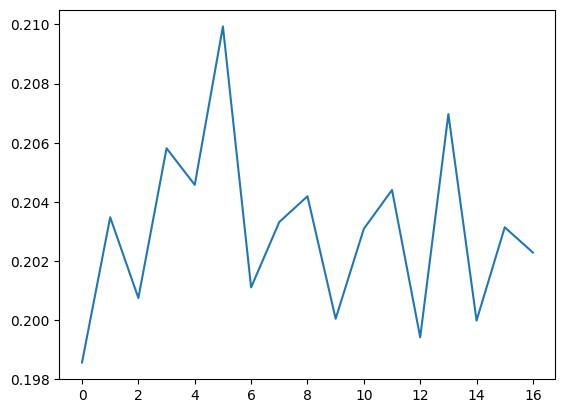

In [17]:
plt.plot(topsim_over_time)

In [24]:
round(max(topsim_over_time) - min(topsim_over_time), 3)

0.011

Topographic similarity changes by at most 0.011 points over time. The best estimate of the 'true' topsim score would probably be to take samples from all phases of training and calculate the average. But also any other sampling method should return a value that is close enough to the true value.